In [2]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from pathlib import Path
from random import randint
import numpy as np
import pandas as pd

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(42)
sns.set_style('whitegrid')
pd.options.display.float_format = '{:,.2f}'.format

DATA_DIR = Path('data')

In [3]:
path = DATA_DIR / 'bbc'
files = sorted(list(path.glob('**/*.txt')))
doc_list = []
for i, file in enumerate(files):
    with open(str(file), encoding='latin1') as f:
        topic = file.parts[-2]
        lines = f.readlines()
        heading = lines[0].strip()
        body = ' '.join([l.strip() for l in lines[1:]])
        doc_list.append([topic.capitalize(), heading, body])

# Convert to DataFrame
docs = pd.DataFrame(doc_list, columns=['Category', 'Heading', 'Article'])
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  2225 non-null   object
 1   Heading   2225 non-null   object
 2   Article   2225 non-null   object
dtypes: object(3)
memory usage: 52.3+ KB


In [4]:
# Create Train & Test Sets
train_docs, test_docs = train_test_split(docs, stratify=docs.Category, test_size=50, random_state=42)
train_docs.shape, test_docs.shape

((2175, 3), (50, 3))

In [5]:
pd.Series(test_docs.Category).value_counts()

Sport            12
Business         11
Entertainment     9
Tech              9
Politics          9
Name: Category, dtype: int64

In [6]:
# Vectorize train & test sets
vectorizer = TfidfVectorizer(max_df=.2, min_df=.01, stop_words='english')

train_dtm = vectorizer.fit_transform(train_docs.Article)
words = vectorizer.get_feature_names()
train_dtm

<2175x2907 sparse matrix of type '<class 'numpy.float64'>'
	with 205235 stored elements in Compressed Sparse Row format>

In [7]:
test_dtm = vectorizer.transform(test_docs.Article)
test_dtm

<50x2907 sparse matrix of type '<class 'numpy.float64'>'
	with 4649 stored elements in Compressed Sparse Row format>

In [8]:
# Get token counts
train_token_count = train_dtm.sum(0).A.squeeze()
tokens = vectorizer.get_feature_names()
word_count = pd.Series(train_token_count, index=tokens).sort_values(ascending=False)
word_count.head(10)

film       41.47
game       36.54
best       36.33
labour     32.75
music      30.97
company    29.73
election   28.09
england    28.08
market     27.67
party      27.44
dtype: float64

In [9]:
# probabilistic Latent Semantic Analysis: pLSA
# pLSA is both symmetric and asymmetric formulations of how word-document co-occurrences come about.
# 1) symmetric formulations assume that both words and documents are generated by the latent topic class.
# 2) asymmetric model assumes that topics are selected given the document, and words result in a second step given the topic.
# # of topics(hyperparameter) - chosen prior to training and is not learned from the data
n_components = 5
topic_labels = ['Topic {}'.format(i) for i in range(1, n_components+1)]
# NMF: Non-Negative Matrix Factorization (NMF) - same with pLSA
nmf = NMF(n_components=n_components, random_state=42, solver='mu', beta_loss='kullback-leibler',
          max_iter=1000)
nmf.fit(train_dtm)

NMF(beta_loss='kullback-leibler', max_iter=1000, n_components=5,
    random_state=42, solver='mu')

In [10]:
nmf.reconstruction_err_

315.9373470674159

In [11]:
# Explore Topics
train_doc_topics = nmf.transform(train_dtm)
train_doc_topics.shape

(2175, 5)

In [12]:
i = randint(0, len(train_docs))
(train_docs.iloc[i, :2].append(pd.Series(train_doc_topics[i], index=topic_labels)))

Category                        Entertainment
Heading     Oasis star fined for German brawl
Topic 1                                  0.03
Topic 2                                  0.01
Topic 3                                  0.02
Topic 4                                  0.03
Topic 5                                  0.00
dtype: object

In [13]:
train_result = pd.DataFrame(data=train_doc_topics, columns=topic_labels, index=train_docs.Category)
test_eval = pd.DataFrame(data=nmf.transform(test_dtm), columns=topic_labels, index=test_docs.Category)

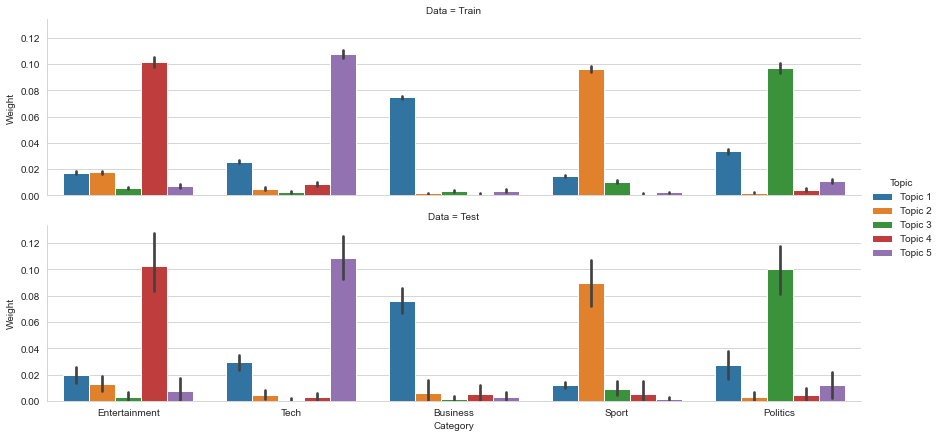

In [14]:
result = pd.melt(train_result.assign(Data='Train').append(test_eval.assign(Data='Test')).reset_index(),
                 id_vars=['Data', 'Category'], var_name='Topic', value_name='Weight')

result = pd.melt(train_result.assign(Data='Train').append(test_eval.assign(Data='Test')).reset_index(),
                 id_vars=['Data', 'Category'], var_name='Topic', value_name='Weight')

g =sns.catplot(x='Category', y='Weight', hue='Topic', row='Data', kind='bar', data=result, height=3, aspect=4);
# Because of the probabilistic nature, pLSA produces only positive topic weight(more straightforward topic-category relationship)

In [15]:
topics = pd.DataFrame(nmf.components_.T, index=tokens, columns=topic_labels)
topics.loc[word_count.head(10).index]

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
film,0.01,0.00,0.00,0.95,0.00
game,0.00,0.53,0.00,0.00,0.12
best,0.05,0.15,0.02,0.53,0.00
labour,0.02,0.00,0.67,0.00,0.00
music,0.00,0.00,0.00,0.37,0.30
company,0.38,0.00,0.00,0.00,0.00
election,0.03,0.00,0.56,0.00,0.00
england,0.04,0.38,0.07,0.00,0.00
market,0.35,0.00,0.00,0.00,0.00
party,0.01,0.00,0.55,0.01,0.02


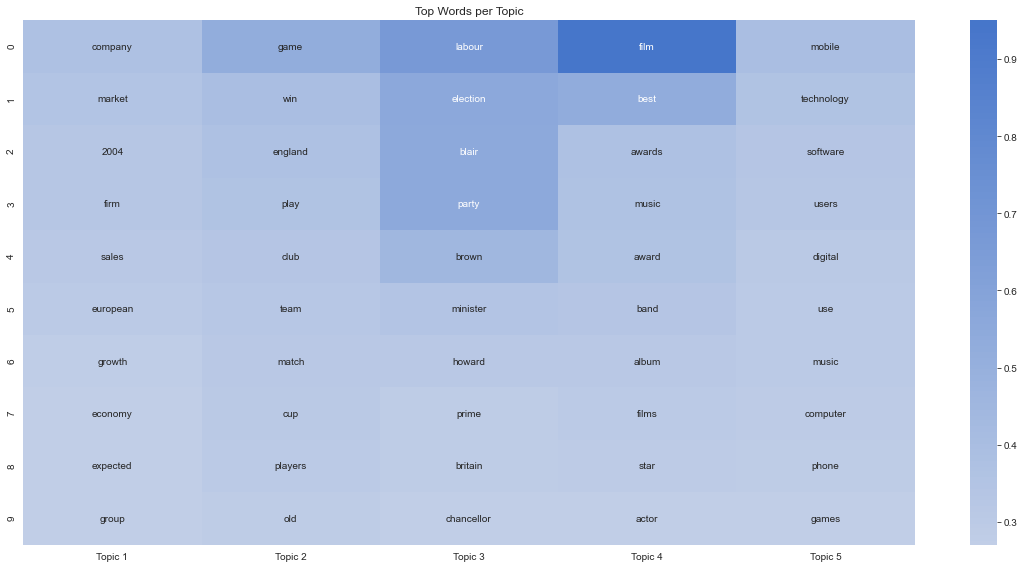

In [16]:
fig, ax = plt.subplots(figsize=(16, 10))
top_words, top_vals = pd.DataFrame(), pd.DataFrame()
for topic, words_ in topics.items():
    top10 = words_.nlargest(10).index
    vals = words_.loc[top10].values
    top_vals[topic] = vals
    top_words[topic] = top10.tolist()

sns.heatmap(pd.DataFrame(top_vals), annot=top_words, fmt = '', center=0,
            cmap=sns.diverging_palette(0, 255, sep=1, n=256), ax=ax);
ax.set_title('Top Words per Topic')
fig.tight_layout();

In [17]:
topics = pd.DataFrame(nmf.components_.T, index=words, columns=topic_labels)
topics.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
000m,0.00,0.07,0.00,0.00,0.00
10,0.18,0.07,0.00,0.08,0.00
100,0.10,0.00,0.00,0.00,0.04
100m,0.02,0.05,0.00,0.00,0.00
11,0.10,0.02,0.00,0.07,0.00


In [18]:
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(10).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,company,game,labour,film,mobile
1,market,win,election,best,technology
2,2004,england,blair,awards,software
3,firm,play,party,music,users
4,sales,club,brown,award,digital
5,european,team,minister,band,use
6,growth,match,howard,album,music
7,economy,cup,prime,films,computer
8,expected,players,britain,star,phone
9,group,old,chancellor,actor,games
